# WaveCalib Class [v1.1]

In [1]:
%matplotlib inline

In [2]:
# imports
import os
from importlib import reload

from astropy.table import Table

from pypit import wavecalib

In [3]:
# Path to PYPIT-Development-suite
pypdev_path = os.getenv('PYPIT_DEV')

# User options

## Explore 1D solution

#### Load MasterFrame

In [4]:
reload(wavecalib)
Wavecalib = wavecalib.WaveCalib(None, spectrograph='shane_kast_blue')
Wavecalib.load_wv_calib(pypdev_path+'/Cooked/WaveCalib/MasterWaveCalib_ShaneKastBlue_A.json')

[WARNING] :: masterframe.py 57 __init__() - MasterFrame class not proper loaded (e.g. no masters in settings).  Avoid using Master methods
[INFO]    :: armasters.py 229 _load() - Loading Master wv_calib frame:
             /home/xavier/local/Python/PYPIT-development-suite//Cooked/WaveCalib/MasterWaveCalib_ShaneKastBlue_A.json


In [5]:
Wavecalib.wv_calib.keys()

dict_keys(['0', 'arcparam', 'steps'])

#### Show spectrum with detected lines

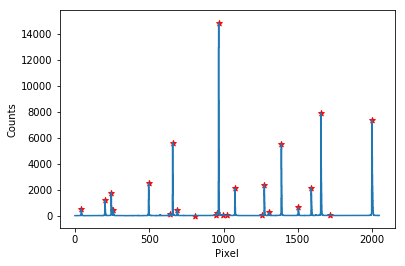

In [6]:
Wavecalib.show('spec', slit=0)

#### Show IDs and fit

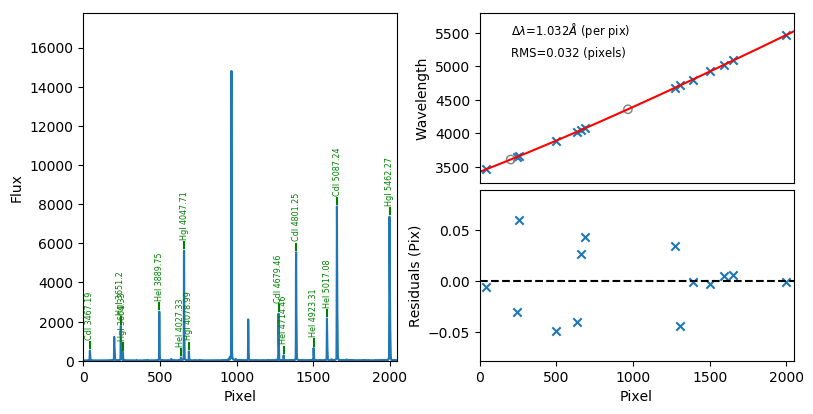

In [7]:
Wavecalib.show('fit', slit=0)

## Redo

#### Check arcparam
    Main item to fuss with is min_ampl

In [8]:
Wavecalib.arcparam

{'Nstrong': 13,
 'b1': 0.000688935788,
 'b2': -2.38634231e-08,
 'disp': 1.02,
 'disp_toler': 0.1,
 'func': 'legendre',
 'lamps': ['CdI', 'HgI', 'HeI'],
 'match_toler': 3.0,
 'min_ampl': 300.0,
 'n_final': 4,
 'n_first': 1,
 'nsig_rej': 2.0,
 'nsig_rej_final': 3.0,
 'wv_cen': 4250.0,
 'wvmnx': [2900.0, 6000.0]}

In [9]:
Wavecalib.arcparam['min_ampl'] = 1000.

#### Rerun

In [10]:
new_wv_calib = Wavecalib.calibrate_spec(0)

---------------------------------------------------
Report:
::   Number of lines recovered    = 24
::   Number of lines analyzed     = 24
::   Number of acceptable matches = 22
::   Best central wavelength      = 4407.67A
::   Best dispersion              = 1.05912A/pix
::   Best solution used pix_tol   = 1.0
::   Best solution had unknown    = True
---------------------------------------------------


----

# Development

In [14]:
from pypit import traceslits
from pypit import arcimage

## Load up required MasterFrames

In [15]:
settings = dict(masters={})
settings['masters']['directory'] = pypdev_path+'/Cooked/MF_shane_kast_blue'
settings['masters']['reuse'] = True

In [16]:
setup = 'A_01_aa'

### MasterArc

In [17]:
AImg = arcimage.ArcImage(setup=setup, settings=settings)
msarc, header, _ = AImg.load_master_frame()

[WARNING] :: processimages.py 97 __init__() - No information on the spectrograph was given.  Do not attempt to (re)process the images
[INFO]    :: armasters.py 241 _load() - Loading a pre-existing master calibration frame
[INFO]    :: armasters.py 243 _load() - Master arc frame loaded successfully:
             /home/xavier/local/Python/PYPIT-development-suite//Cooked/MF_shane_kast_blue/MasterArc_A_01_aa.fits


### TraceSlits

In [18]:
TSlits = traceslits.TraceSlits.from_master_files(settings['masters']['directory']+'/MasterTrace_A_01_aa')
TSlits._make_pixel_arrays()

[INFO]    :: traceslits.py 207 from_master_files() - Loading BPM from /home/xavier/local/Python/PYPIT-development-suite//Cooked/MF_shane_kast_blue/MasterTrace_A_01_aa.fits.gz
[INFO]    :: traceslits.py 518 _make_pixel_arrays() - Converting physical trace locations to nearest pixel
[INFO]    :: traceslits.py 525 _make_pixel_arrays() - Identifying the pixels belonging to each slit


### Fitstbl

In [19]:
fitstbl = Table.read(settings['masters']['directory']+'/shane_kast_blue_setup_A.fits')

## Init Wavecalib

In [20]:
reload(wavecalib)
Wavecalib = wavecalib.WaveCalib(msarc, spectrograph='shane_kast_blue', settings=settings, setup=setup, fitstbl=fitstbl, sci_ID=1, det=1)

## Extract arcs -- Requires msarc and slit info

In [21]:
arccen, maskslits = Wavecalib._extract_arcs(TSlits.lcen, TSlits.rcen, TSlits.pixlocn)

[INFO]    :: ararc.py 86 get_censpec() - Extracting an approximate arc spectrum at the centre of each slit


In [22]:
arccen.shape

(2048, 1)

## Arcparam -- Requires fitstbl, sci_ID, det

In [23]:
arcparam = Wavecalib._load_arcparam()

[WARNING] :: arparse.py 4478 parse_binning() - Unable to parse input binning: None
[WARNING] :: arparse.py 4479 parse_binning() - Assuming unbinned, i.e.  1x1
[INFO]    :: ararc.py 459 setup_param() - Loading line list using CdI,HgI,HeI lamps
[INFO]    :: ararclines.py 68 load_arcline_list() - Rejecting select CdI lines
[INFO]    :: ararclines.py 68 load_arcline_list() - Rejecting select HgI lines
[INFO]    :: ararclines.py 76 load_arcline_list() - Cutting down line list by wvmnx: 2900,6000


In [24]:
arcparam

{'Nstrong': 13,
 'b1': 0.000688935788,
 'b2': -2.38634231e-08,
 'disp': 1.02,
 'disp_toler': 0.1,
 'func': 'legendre',
 'lamps': ['CdI', 'HgI', 'HeI'],
 'llist': <Table masked=True length=54>
 Ion     wave    RelInt
 str5  float64  float64
 ---- --------- -------
  CdI 3081.7172   150.0
  CdI 3083.4887    30.0
  CdI 3134.0746   200.0
  CdI 3253.4622   300.0
  CdI 3261.9951   300.0
  CdI 3404.6287   800.0
  CdI 3467.1923  1000.0
  CdI 3468.6477   800.0
  CdI 3500.9531    25.0
  CdI 3611.5375  1000.0
  ...       ...     ...
  HeI  4472.735   200.0
  HeI  4472.735   200.0
  HeI 4714.4644    30.0
  HeI 4714.4644    30.0
  HeI 4923.3053    20.0
  HeI 5017.0772   100.0
  HeI  5877.249   500.0
  HeI  5877.249   500.0
  HeI  5877.249   500.0
  HeI  5877.249   500.0,
 'match_toler': 3.0,
 'min_ampl': 300.0,
 'n_final': 4,
 'n_first': 1,
 'nsig_rej': 2.0,
 'nsig_rej_final': 3.0,
 'wv_cen': 4250.0,
 'wvmnx': [2900.0, 6000.0]}

## Build wv_calib

In [25]:
wv_calib = Wavecalib._build_wv_calib('arclines', skip_QA=True)

---------------------------------------------------
Report:
::   Number of lines recovered    = 24
::   Number of lines analyzed     = 24
::   Number of acceptable matches = 22
::   Best central wavelength      = 4407.67A
::   Best dispersion              = 1.05912A/pix
::   Best solution used pix_tol   = 1.0
::   Best solution had unknown    = True
---------------------------------------------------


In [26]:
wv_calib

{'0': {'fitc': array([  4.43581701e+03,   1.04860313e+03,   3.62635165e+01,
          -4.99601432e+00,  -3.79828867e-02,   2.16016177e-01]),
  'fmax': 1.0,
  'fmin': 0.0,
  'function': 'legendre',
  'ions': array(['CdI', 'HgI', 'HgI', 'HeI', 'HeI', 'HgI', 'HgI', 'CdI', 'HeI',
         'CdI', 'HeI', 'HeI', 'CdI', 'HgI'],
        dtype='<U6'),
  'mask': array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
  'nrej': 3.0,
  'rms': 0.031038994452921714,
  'shift': 0.0,
  'spec': array([ 17.36,  18.02,  12.78, ...,  28.88,  29.8 ,  29.78]),
  'tcent': array([   43.51323142,   202.33949841,   244.7506111 ,   258.75505693,
           496.26538515,   637.12838659,   657.69446875,   689.24067019,
           804.59865913,   948.67102361,   956.68862798,   966.90892385,
           995.76670855,  1020.08278726,  1076.58514325,  1259.24225678,
          1274.11166445,  1307.29940066,  1388.99228235,  1503.14401693,
          1590.27063148,  1655.17360085,  1718.56434391,  1998.41116872]),
  'xfi

## Save as master

In [27]:
Wavecalib.save_master(wv_calib,outfile='tmp.json')  # This doesn't save steps nor arcparam which *is* done in the master() call

[INFO]    :: armasters.py 374 core_save_master() - Saving master wv_calib frame as:
             tmp.json
[INFO]    :: armasters.py 407 core_save_master() - Master wv_calib frame saved successfully:
             tmp.json


## One shot

In [31]:
reload(wavecalib)
settings['masters']['reuse'] = False
settings['masters']['force'] = False
Wavecalib = wavecalib.WaveCalib(msarc, spectrograph='shane_kast_blue', settings=settings, setup=setup, fitstbl=fitstbl, sci_ID=1, det=1)
wv_calib2, _ = Wavecalib.run(TSlits.lcen, TSlits.rcen, TSlits.pixlocn, skip_QA=True)

[INFO]    :: ararc.py 86 get_censpec() - Extracting an approximate arc spectrum at the centre of each slit
[WARNING] :: arparse.py 4478 parse_binning() - Unable to parse input binning: None
[WARNING] :: arparse.py 4479 parse_binning() - Assuming unbinned, i.e.  1x1
[INFO]    :: ararc.py 459 setup_param() - Loading line list using CdI,HgI,HeI lamps
[INFO]    :: ararclines.py 68 load_arcline_list() - Rejecting select CdI lines
[INFO]    :: ararclines.py 68 load_arcline_list() - Rejecting select HgI lines
[INFO]    :: ararclines.py 76 load_arcline_list() - Cutting down line list by wvmnx: 2900,6000


---------------------------------------------------
Report:
::   Number of lines recovered    = 24
::   Number of lines analyzed     = 24
::   Number of acceptable matches = 22
::   Best central wavelength      = 4407.67A
::   Best dispersion              = 1.05912A/pix
::   Best solution used pix_tol   = 1.0
::   Best solution had unknown    = True
---------------------------------------------------


In [32]:
wv_calib2.keys()

dict_keys(['0', 'steps', 'arcparam'])